<a href="https://colab.research.google.com/github/shima2920/COVID-19_TOKYO/blob/main/COVID_19_TOKYO_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

In [2]:
df = pd.read_csv('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv')

In [3]:
df.tail()

,No,全国地方公共団体コード,都道府県名,市区町村名,公表_年月日,発症_年月日,確定_年月日,患者_居住地,患者_年代,患者_性別,患者_職業,患者_状態,患者_症状,患者_渡航歴の有無フラグ,患者_接触歴の有無フラグ,備考,退院済フラグ
117699,116816,130001,東京都,NaN,2021-03-22,NaN,NaN,NaN,40代,男性,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117700,116817,130001,東京都,NaN,2021-03-22,NaN,NaN,NaN,10代,男性,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117701,116818,130001,東京都,NaN,2021-03-22,NaN,NaN,NaN,60代,女性,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117702,116819,130001,東京都,NaN,2021-03-22,NaN,NaN,NaN,60代,女性,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117703,116820,130001,東京都,NaN,2021-03-22,NaN,NaN,NaN,20代,男性,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df1 = df.groupby(["公表_年月日"]).count()["都道府県名"].reset_index()
df1 = df1.rename(index = str,columns={'都道府県名': '人数'})
df1.head(5)

,公表_年月日,人数
0,2020-01-24,1
1,2020-01-25,1
2,2020-01-30,1
3,2020-02-13,1
4,2020-02-14,2


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


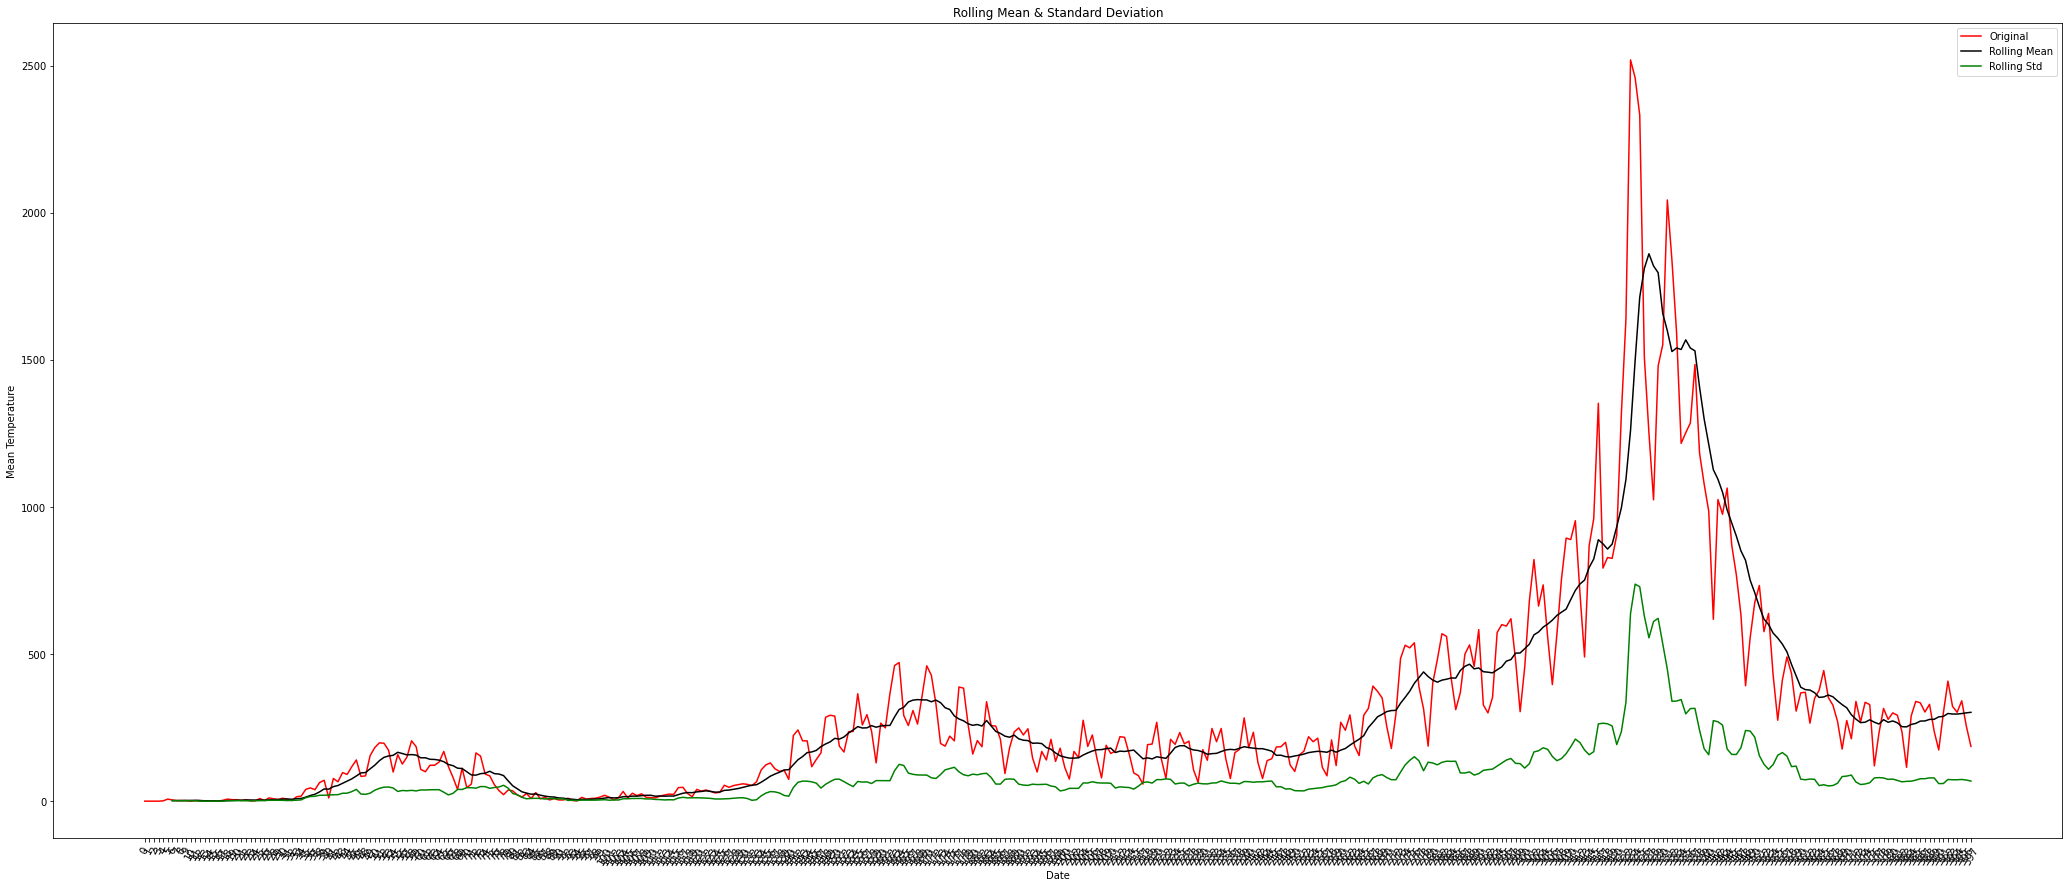

Test statistic:  -2.4821467492188214
p-value:  0.11987886152606014
Critical Values: {'1%': -3.4476763783532585, '5%': -2.869176103659426, '10%': -2.570837873961219}


In [5]:
# adfuller library 
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
# check_mean_std
def check_mean_std(ts):
    #Rolling statistics
    #rolmean = pd.rolling_mean(ts, window=6)
    rolmean = ts.rolling(7).mean()
    #rolstd = pd.rolling_std(ts, window=6)
    rolstd = ts.rolling(7).std()
    plt.figure(figsize=(36,15))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=60)
    plt.legend()
    plt.show()
    
# check stationary: mean, variance(std)and adfuller test
check_mean_std(df1['人数'])
check_adfuller(df1['人数'])

<Figure size 10368x7776 with 0 Axes>

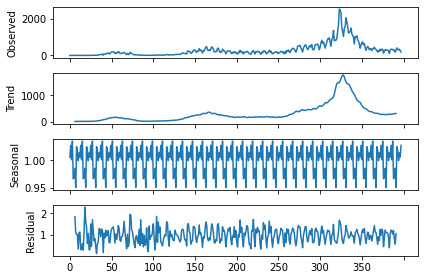

In [6]:
# 時系列データを傾向変動・季節変動・残差に分解する
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(df1['人数'],freq=12,model="multiplicative")
plt.figure(figsize=(144,108))
fig = res.plot()
#fig.show()

In [7]:
# 列名を日時はds、目的変数をyに変更する。Prophetの仕様のため。
new_df = df1.rename(columns={'公表_年月日': 'ds', '人数': 'y'})
new_df.head()

,ds,y
0,2020-01-24,1
1,2020-01-25,1
2,2020-01-30,1
3,2020-02-13,1
4,2020-02-14,2


In [8]:
# 予測したい数
predict_num = 100
# 訓練データの作成する。全データから予測したい数を引いた数
#cnt = len(new_df) - predict_num
#train_df = new_df[:cnt]
train_df = new_df
train_df.tail()

,ds,y
393,2021-03-18,323
394,2021-03-19,303
395,2021-03-20,342
396,2021-03-21,256
397,2021-03-22,187


In [9]:
event_dataframe = pd.read_csv('event_dataframe_2.csv')

In [10]:
event_dataframe.head()

,holiday,ds
0,建国記念の日,2020/2/11
1,天皇誕生日,2020/2/23
2,振替休日,2020/2/24
3,春分の日,2020/3/20
4,緊急事態宣言発出,2020/4/7


In [11]:
from fbprophet import Prophet
# モデルの作成
model = Prophet(
    growth='logistic', # 傾向変動の関数．非線形は'logistic'一般的なビジネス/金融データは非線形なのでlogistic。
    yearly_seasonality = True, # 年次の季節変動を考慮有無
    weekly_seasonality = True, # 週次の季節変動を考慮有無
    daily_seasonality = False, # 日次の季節変動を考慮有無
    changepoints = None, #  傾向変化点のリスト 
    changepoint_range = 1, # 傾向変化点の候補の幅で先頭からの割合。
    changepoint_prior_scale = 0.5, # 傾向変化点の事前分布のスケール値。パラメータの柔軟性 トレンドの変化がオーバーフィット（柔軟性が高すぎる）またはアンダーフィット（柔軟性が不十分）の場合、 入力引数を使用する前にスパースの強度を調整できます。
    n_changepoints = 5, # 傾向変化点の数 changepointの場所を手動で設定したい場合これを使う Changepointとは、データ中で「トレンドが大きく変わったと思われる」点のことです。 changepointは自動検出されるが、手動でカスタマイズできる。 n_changepointsではトレンドの変更点の数を手動で設定できる。デフォルトでは25。
    holidays= event_dataframe
) 
train_df['cap'] = 3000 # logisticモデルを選択する場合は必ずcapの設定が必須。最大値は'cap'、最小値は'floor'で指定できる
model.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [12]:
# 学習データに予測したい期間を追加する
future = model.make_future_dataframe(periods = predict_num) #,freq='M')
future.tail()

,ds
493,2021-06-26
494,2021-06-27
495,2021-06-28
496,2021-06-29
497,2021-06-30


In [13]:
# 予測する
future['cap'] = 3000
forecast = model.predict(future)
forecast.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,こどもの日,こどもの日_lower,こどもの日_upper,みどりの日,みどりの日_lower,みどりの日_upper,スポーツの日,スポーツの日_lower,スポーツの日_upper,スポーツの日＜東京五輪開会式予定＞,スポーツの日＜東京五輪開会式予定＞_lower,スポーツの日＜東京五輪開会式予定＞_upper,勤労感謝の日,勤労感謝の日_lower,勤労感謝の日_upper,天皇誕生日,天皇誕生日_lower,天皇誕生日_upper,山の日,山の日_lower,山の日_upper,山の日振替,山の日振替_lower,山の日振替_upper,山の日＜東京五輪閉会式予定＞,山の日＜東京五輪閉会式予定＞_lower,山の日＜東京五輪閉会式予定＞_upper,年末年始,年末年始_lower,年末年始_upper,建国記念の日,建国記念の日_lower,建国記念の日_upper,憲法記念日,憲法記念日_lower,憲法記念日_upper,成人の日,成人の日_lower,成人の日_upper,振替休日,振替休日_lower,振替休日_upper,敬老の日,敬老の日_lower,敬老の日_upper,文化の日,文化の日_lower,文化の日_upper,春分の日,春分の日_lower,春分の日_upper,昭和の日,昭和の日_lower,昭和の日_upper,海の日,海の日_lower,海の日_upper,海の日＜東京五輪開会式前日予定＞,海の日＜東京五輪開会式前日予定＞_lower,海の日＜東京五輪開会式前日予定＞_upper,秋分の日,秋分の日_lower,秋分の日_upper,緊急事態宣言発出,緊急事態宣言発出_lower,緊急事態宣言発出_upper,緊急事態宣言解除,緊急事態宣言解除_lower,緊急事態宣言解除_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-24,58.576368,3000,461.532963,745.711843,58.576368,58.576368,537.313150,537.313150,537.313150,0.0,0.0,0.0,49.208262,49.208262,49.208262,488.104888,488.104888,488.104888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,595.889518
1,2020-01-25,59.012019,3000,396.251614,684.715456,59.012019,59.012019,481.923211,481.923211,481.923211,0.0,0.0,0.0,53.743675,53.743675,53.743675,428.179537,428.179537,428.179537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,540.935231
2,2020-01-30,61.238341,3000,147.717928,440.920957,61.238341,61.238341,232.290325,232.290325,232.290325,0.0,0.0,0.0,69.548212,69.548212,69.548212,162.742113,162.742113,162.742113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293.528667
3,2020-02-13,67.918519,3000,-129.271367,161.546149,67.918519,67.918519,-52.065004,-52.065004,-52.065004,0.0,0.0,0.0,69.548212,69.548212,69.548212,-121.613216,-121.613216,-121.613216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.853515
4,2020-02-14,68.422035,3000,-136.173499,134.195294,68.422035,68.422035,-74.245379,-74.245379,-74.245379,0.0,0.0,0.0,49.208262,49.208262,49.208262,-123.453641,-123.453641,-123.453641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.823344


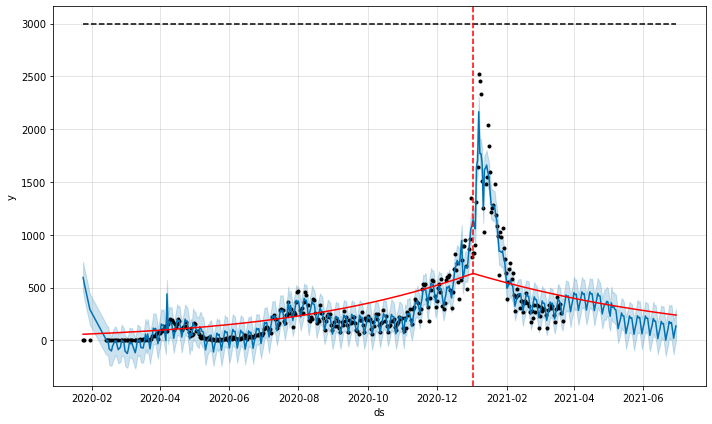

In [14]:
# 可視化する
import matplotlib.pyplot as plt
from fbprophet.plot import add_changepoints_to_plot
forecast['cap'] = 3000
#forecast['floor'] = 21000
fig1 = model.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)
plt.show()

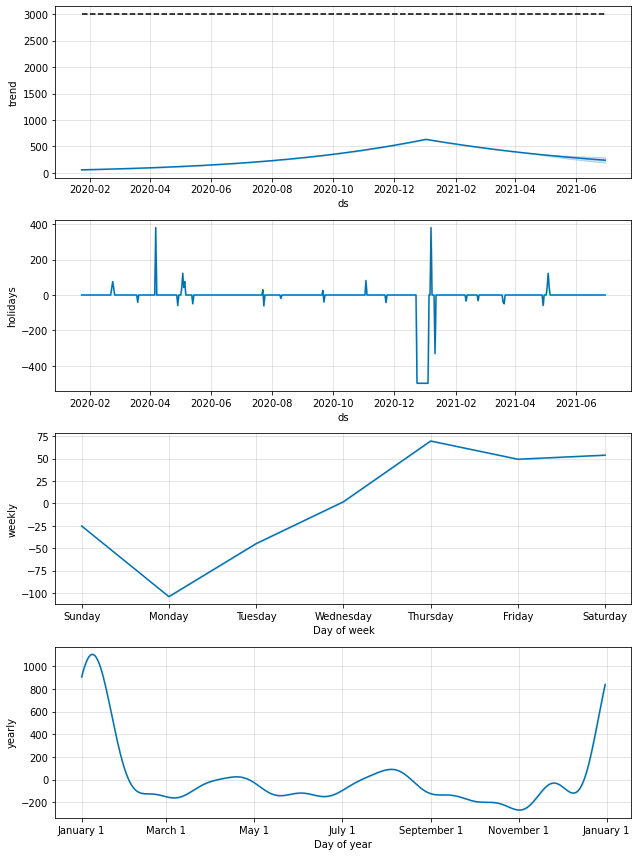

In [15]:
# 規則性を可視化
fig2 = model.plot_components(forecast)
plt.show()

In [16]:
model.changepoints.index

Int64Index([79, 159, 238, 318, 397], dtype='int64')

In [17]:
train_df.index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '388', '389', '390', '391', '392', '393', '394', '395', '396', '397'],
      dtype='object', length=398)

In [18]:
import seaborn as sns

# 変化率を追記
df3 = train_df.iloc[model.changepoints.index]
df3['delta'] = model.params['delta'].ravel()

# 変化点を取得
df3['ds'] = df3['ds'].astype(str)
df3['delta'] = df3['delta'].round(3)
df4 = df3[df3['delta'] != 0]
print(df4)

             ds    y   cap  delta
318  2021-01-02  829  3000 -5.857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [19]:
df4.head(5)

,ds,y,cap,delta
318,2021-01-02,829,3000,-5.857


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



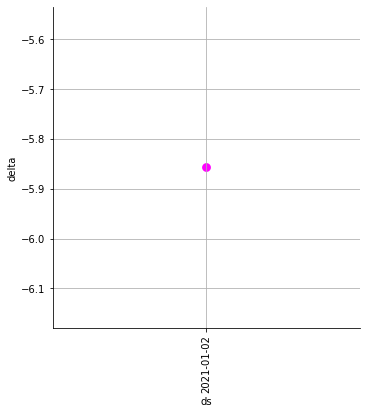

['2021-01-02']


In [20]:
# 変化点をグラフ化
import matplotlib.pyplot as plt
ax = sns.factorplot(x = 'ds', y = 'delta', data = df4, color='magenta')
ax.set_xticklabels(rotation=90)
plt.grid()
plt.show()
# 変化点をリストで抽出
ds_list = df4['ds'].tolist()
print(ds_list)


In [21]:
# 変化点を指定してモデルの作成
model2 = Prophet(
    growth='logistic', # 傾向変動の関数．非線形は'logistic'
    yearly_seasonality = True, # 年次の季節変動を考慮有無
    weekly_seasonality = True, # 週次の季節変動を考慮有無
    daily_seasonality = False, # 日次の季節変動を考慮有無
    changepoints = ds_list, #  傾向変化点のリスト
    #changepoint_range = 0.85, # 傾向変化点の候補の幅で先頭からの割合。
    #changepoint_prior_scale = 0.5, # 傾向変化点の事前分布のスケール値。パラメータの柔軟性
    #n_changepoints = 5, # 傾向変化点の数
    holidays= event_dataframe
) 
model2.fit(train_df)

In [22]:
# 学習データに予測したい期間を追加する
future2 = model2.make_future_dataframe(periods = predict_num) #,freq='M')
future2.tail()

,ds
493,2021-06-26
494,2021-06-27
495,2021-06-28
496,2021-06-29
497,2021-06-30


In [23]:
# 予測2
future2['cap'] = 3000
forecast2 = model2.predict(future2)
forecast2.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,こどもの日,こどもの日_lower,こどもの日_upper,みどりの日,みどりの日_lower,みどりの日_upper,スポーツの日,スポーツの日_lower,スポーツの日_upper,スポーツの日＜東京五輪開会式予定＞,スポーツの日＜東京五輪開会式予定＞_lower,スポーツの日＜東京五輪開会式予定＞_upper,勤労感謝の日,勤労感謝の日_lower,勤労感謝の日_upper,天皇誕生日,天皇誕生日_lower,天皇誕生日_upper,山の日,山の日_lower,山の日_upper,山の日振替,山の日振替_lower,山の日振替_upper,山の日＜東京五輪閉会式予定＞,山の日＜東京五輪閉会式予定＞_lower,山の日＜東京五輪閉会式予定＞_upper,年末年始,年末年始_lower,年末年始_upper,建国記念の日,建国記念の日_lower,建国記念の日_upper,憲法記念日,憲法記念日_lower,憲法記念日_upper,成人の日,成人の日_lower,成人の日_upper,振替休日,振替休日_lower,振替休日_upper,敬老の日,敬老の日_lower,敬老の日_upper,文化の日,文化の日_lower,文化の日_upper,春分の日,春分の日_lower,春分の日_upper,昭和の日,昭和の日_lower,昭和の日_upper,海の日,海の日_lower,海の日_upper,海の日＜東京五輪開会式前日予定＞,海の日＜東京五輪開会式前日予定＞_lower,海の日＜東京五輪開会式前日予定＞_upper,秋分の日,秋分の日_lower,秋分の日_upper,緊急事態宣言発出,緊急事態宣言発出_lower,緊急事態宣言発出_upper,緊急事態宣言解除,緊急事態宣言解除_lower,緊急事態宣言解除_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-24,131.506044,3000,587.883958,887.924751,131.506044,131.506044,601.756031,601.756031,601.756031,0.0,0.0,0.0,47.465538,47.465538,47.465538,554.290493,554.290493,554.290493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,733.262075
1,2020-01-25,132.001906,3000,528.512377,822.893961,132.001906,132.001906,540.746420,540.746420,540.746420,0.0,0.0,0.0,52.206950,52.206950,52.206950,488.539470,488.539470,488.539470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,672.748327
2,2020-01-30,134.508083,3000,234.870249,535.919347,134.508083,134.508083,265.248568,265.248568,265.248568,0.0,0.0,0.0,68.829121,68.829121,68.829121,196.419447,196.419447,196.419447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399.756651
3,2020-02-13,141.768760,3000,-81.280682,218.806281,141.768760,141.768760,-73.215893,-73.215893,-73.215893,0.0,0.0,0.0,68.829121,68.829121,68.829121,-142.045015,-142.045015,-142.045015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.552867
4,2020-02-14,142.301399,3000,-100.086193,197.803718,142.301399,142.301399,-99.841746,-99.841746,-99.841746,0.0,0.0,0.0,47.465538,47.465538,47.465538,-147.307283,-147.307283,-147.307283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.459654


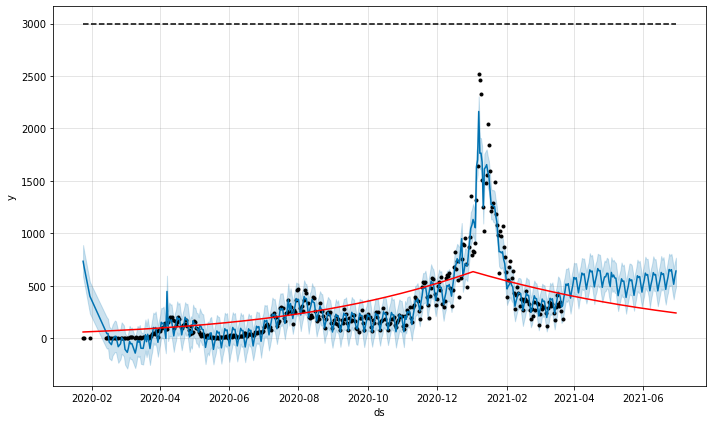

In [24]:
# 可視化
forecast2['cap'] = 3000
#forecast['floor'] = 21000
fig2_1 = model2.plot(forecast2)
b = add_changepoints_to_plot(fig2_1.gca(), model2, forecast)
plt.show()

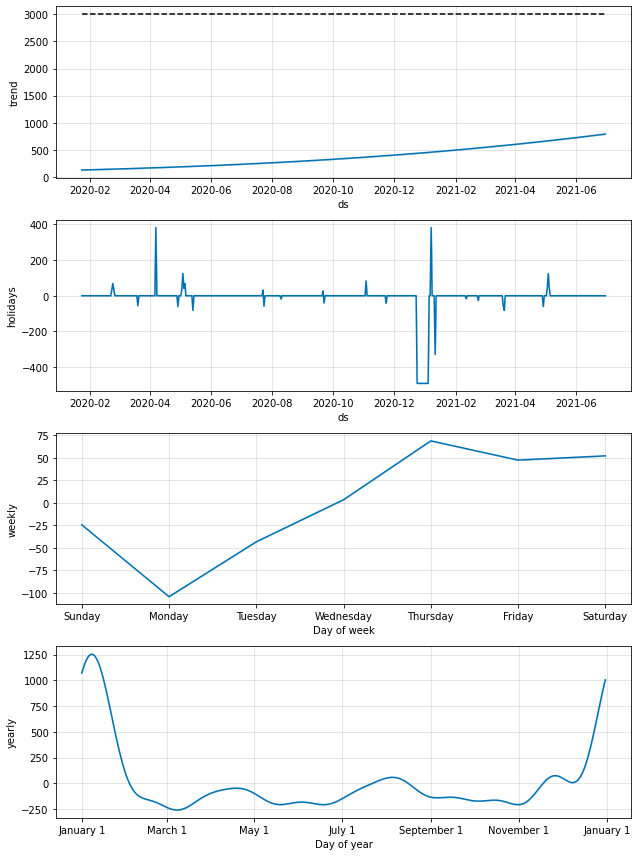

In [25]:
# 規則性を可視化
fig2_2 = model2.plot_components(forecast2)
plt.show()

In [26]:
print('\nThe rmse of prediction is:', np.sqrt(mean_squared_error(df1['人数'] , forecast2[:-100]['yhat'] )) ** 0.5)


The rmse of prediction is: 10.75334983865432


In [27]:
# モデルを保存する
import json
from fbprophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(model2), fout)

In [28]:
# モデルをロードする
import json
from fbprophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'rb') as fin:
    model3 = model_from_json(json.load(fin))

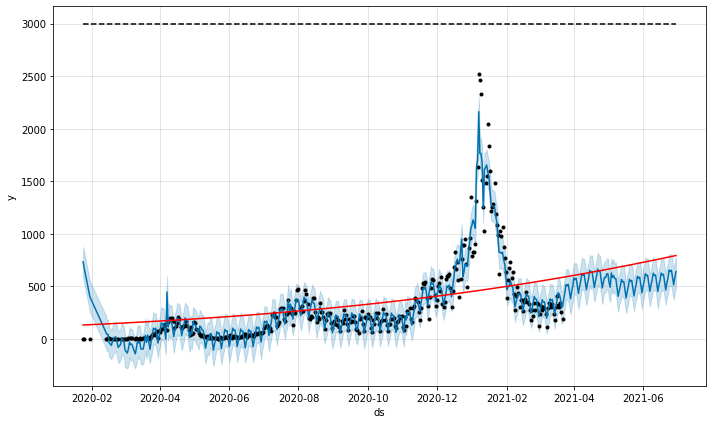

In [29]:
# (更に先の2021年4-6月頃の)未来を予測する
import fbprophet.plot as fp
future3 = model3.make_future_dataframe(periods=100)
future3['cap'] = 3000
forecast3 = model3.predict(future3)
fig3 = model3.plot(forecast3)
fp.add_changepoints_to_plot(fig3.gca(), model3, forecast3);
plt.show()

In [30]:
forecast3.tail(100)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,こどもの日,こどもの日_lower,こどもの日_upper,みどりの日,みどりの日_lower,みどりの日_upper,スポーツの日,スポーツの日_lower,スポーツの日_upper,スポーツの日＜東京五輪開会式予定＞,スポーツの日＜東京五輪開会式予定＞_lower,スポーツの日＜東京五輪開会式予定＞_upper,勤労感謝の日,勤労感謝の日_lower,勤労感謝の日_upper,天皇誕生日,天皇誕生日_lower,天皇誕生日_upper,山の日,山の日_lower,山の日_upper,山の日振替,山の日振替_lower,山の日振替_upper,山の日＜東京五輪閉会式予定＞,山の日＜東京五輪閉会式予定＞_lower,山の日＜東京五輪閉会式予定＞_upper,年末年始,年末年始_lower,年末年始_upper,建国記念の日,建国記念の日_lower,建国記念の日_upper,憲法記念日,憲法記念日_lower,憲法記念日_upper,成人の日,成人の日_lower,成人の日_upper,振替休日,振替休日_lower,振替休日_upper,敬老の日,敬老の日_lower,敬老の日_upper,文化の日,文化の日_lower,文化の日_upper,春分の日,春分の日_lower,春分の日_upper,昭和の日,昭和の日_lower,昭和の日_upper,海の日,海の日_lower,海の日_upper,海の日＜東京五輪開会式前日予定＞,海の日＜東京五輪開会式前日予定＞_lower,海の日＜東京五輪開会式前日予定＞_upper,秋分の日,秋分の日_lower,秋分の日_upper,緊急事態宣言発出,緊急事態宣言発出_lower,緊急事態宣言発出_upper,緊急事態宣言解除,緊急事態宣言解除_lower,緊急事態宣言解除_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
398,2021-03-23,587.074750,3000,235.679988,518.157755,587.074750,587.074750,-204.896143,-204.896143,-204.896143,0.000000,0.000000,0.000000,-43.279462,-43.279462,-43.279462,-161.616681,-161.616681,-161.616681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,382.178607
399,2021-03-24,588.935716,3000,295.439350,586.326896,588.935716,588.935716,-149.013419,-149.013419,-149.013419,0.000000,0.000000,0.000000,3.450970,3.450970,3.450970,-152.464389,-152.464389,-152.464389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,439.922297
400,2021-03-25,590.801138,3000,370.996979,662.656733,590.801138,590.801138,-74.782298,-74.782298,-74.782298,0.000000,0.000000,0.000000,68.829121,68.829121,68.829121,-143.611419,-143.611419,-143.611419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,516.018840
401,2021-03-26,592.671016,3000,370.565669,662.463042,592.671016,592.671016,-87.663833,-87.663833,-87.663833,0.000000,0.000000,0.000000,47.465538,47.465538,47.465538,-135.129371,-135.129371,-135.129371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,505.007182
402,2021-03-27,594.545351,3000,363.198735,658.304107,594.545351,594.545351,-74.866668,-74.866668,-74.866668,0.000000,0.000000,0.000000,52.206950,52.206950,52.206950,-127.073619,-127.073619,-127.073619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,519.678683
403,2021-03-28,596.424145,3000,296.648102,599.348509,596.424145,596.424145,-143.901191,-143.901191,-143.901191,0.00

In [31]:
df1.shape

(398, 2)

In [32]:
forecast3[:-100].shape

(398, 92)

In [33]:
forecast3.head(5)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,こどもの日,こどもの日_lower,こどもの日_upper,みどりの日,みどりの日_lower,みどりの日_upper,スポーツの日,スポーツの日_lower,スポーツの日_upper,スポーツの日＜東京五輪開会式予定＞,スポーツの日＜東京五輪開会式予定＞_lower,スポーツの日＜東京五輪開会式予定＞_upper,勤労感謝の日,勤労感謝の日_lower,勤労感謝の日_upper,天皇誕生日,天皇誕生日_lower,天皇誕生日_upper,山の日,山の日_lower,山の日_upper,山の日振替,山の日振替_lower,山の日振替_upper,山の日＜東京五輪閉会式予定＞,山の日＜東京五輪閉会式予定＞_lower,山の日＜東京五輪閉会式予定＞_upper,年末年始,年末年始_lower,年末年始_upper,建国記念の日,建国記念の日_lower,建国記念の日_upper,憲法記念日,憲法記念日_lower,憲法記念日_upper,成人の日,成人の日_lower,成人の日_upper,振替休日,振替休日_lower,振替休日_upper,敬老の日,敬老の日_lower,敬老の日_upper,文化の日,文化の日_lower,文化の日_upper,春分の日,春分の日_lower,春分の日_upper,昭和の日,昭和の日_lower,昭和の日_upper,海の日,海の日_lower,海の日_upper,海の日＜東京五輪開会式前日予定＞,海の日＜東京五輪開会式前日予定＞_lower,海の日＜東京五輪開会式前日予定＞_upper,秋分の日,秋分の日_lower,秋分の日_upper,緊急事態宣言発出,緊急事態宣言発出_lower,緊急事態宣言発出_upper,緊急事態宣言解除,緊急事態宣言解除_lower,緊急事態宣言解除_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-24,131.506044,3000,579.167822,873.744478,131.506044,131.506044,601.756031,601.756031,601.756031,0.0,0.0,0.0,47.465538,47.465538,47.465538,554.290493,554.290493,554.290493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,733.262075
1,2020-01-25,132.001906,3000,534.143431,823.428855,132.001906,132.001906,540.746420,540.746420,540.746420,0.0,0.0,0.0,52.206950,52.206950,52.206950,488.539470,488.539470,488.539470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,672.748327
2,2020-01-30,134.508083,3000,258.626110,548.173136,134.508083,134.508083,265.248568,265.248568,265.248568,0.0,0.0,0.0,68.829121,68.829121,68.829121,196.419447,196.419447,196.419447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399.756651
3,2020-02-13,141.768760,3000,-82.229507,226.343485,141.768760,141.768760,-73.215893,-73.215893,-73.215893,0.0,0.0,0.0,68.829121,68.829121,68.829121,-142.045015,-142.045015,-142.045015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.552867
4,2020-02-14,142.301399,3000,-115.011602,175.432501,142.301399,142.301399,-99.841746,-99.841746,-99.841746,0.0,0.0,0.0,47.465538,47.465538,47.465538,-147.307283,-147.307283,-147.307283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.459654


# 精度評価

In [34]:
print('\nThe rmse of prediction is:', np.sqrt(mean_squared_error(df1['人数'] , forecast[:-100]['yhat'] )) ** 0.5)


The rmse of prediction is: 10.47648623687118


In [35]:
print('\nThe rmse of prediction is:', np.sqrt(mean_squared_error(df1['人数'] , forecast3[:-100]['yhat'] )) ** 0.5)


The rmse of prediction is: 10.75334983865432


# Cross Validation

ref : https://www.kaggle.com/akirayuasa/prophet-easy-time-series-modeling

In [36]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#initialはtrainの期間。そこからhorizon期間分を予測する。これをperiodの期間スライドし、何度も実行する。
#cv = diagnostics.cross_validation(m, horizon='30 days')
cv =cross_validation(model3, initial = '30 days', period = '100 days', horizon = '30 days')
cv.tail()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2020-04-26 00:00:00 and 2021-02-20 00:00:00


AttributeError: ignored

**処理内容確認**

****